Optimisation des paramètres c1 et c2 dans le cas de bruits gaussiens pour la MRW

In [1]:
# Cellule 1 : imports + données
import sys
sys.path.insert(0, '.')

import functions
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Données cibles
data = np.load("Train_TurbModane_N65536_sampling4_Nreal256_v3.npz")
S2 = torch.from_numpy(data['S2'].mean(axis=0)).float()
flatness = torch.from_numpy(data['Flat'].mean(axis=0)).float()
scales = torch.from_numpy(data["scales"]).float()

torch.manual_seed(0)

In [2]:
# Cellule 2 : hyperparamètres
K = 1000        # catégories pour éventuelle discrétisation
N = 2**16       # taille du signal
M = 1           # réalisations
alpha = 0.3     # mix MSE lin / log pour S2
beta = 1.0      # mix MSE lin / log pour flatness
gamma = 0.95    # poids S2 vs flatness
tau = 2         # température Gumbel-Softmax
L = np.exp(8)
c1 = 0.33       # Hurst
c2 = 0.02       # intermittence
delta_sigma = 1.0
h_mu = 0.0
h_sigma = 1.0

print(f"N = {N}")
print(f"L = {L}")

N = 65536
L = 2980.9579870417283


In [3]:
# Cellule 3 : optimisation des paramètres
c1_opt = torch.tensor(c1, requires_grad=True)
c2_opt = torch.tensor(c2, requires_grad=True)
delta_sigma_opt = torch.tensor(delta_sigma)
L_opt = torch.tensor(L)
h_mu_opt = torch.tensor(h_mu)
h_sigma_opt = torch.tensor(h_sigma, requires_grad=True)

learning_rate = 0.001
num_epochs = 50
optimizer = torch.optim.Adam([c1_opt, c2_opt], lr=learning_rate)

# Bruits fixés pour la stabilité
base_noise1 = torch.randn(M, int(N))
base_noise2 = torch.randn(M, int(N))

loss_history = []
print("Début de l'optimisation...")

for epoch in range(num_epochs):
    optimizer.zero_grad()

    noise1 = base_noise1 * h_sigma_opt + h_mu_opt
    noise2 = base_noise2

    MRW = delta_sigma_opt * functions.synthMRWregul_Torch(
        noise1, noise2, int(N), c1_opt, c2_opt, L_opt, epsilon=0.2, win=1
    )
    MRW_reshaped = torch.reshape(MRW, (-1, 2**16))

    moments = functions.analyseIncrsTorchcuda(MRW_reshaped, scales, device='cpu')
    S2_sim = torch.exp(moments[:, 0, :]).mean(dim=0)
    flat_sim = moments[:, 2, :].mean(dim=0)

    mse_lin_S2 = F.mse_loss(S2_sim, S2)
    mse_log_S2 = F.mse_loss(torch.log(S2_sim + 1e-10), torch.log(S2 + 1e-10))
    loss_S2 = alpha * mse_lin_S2 + (1 - alpha) * mse_log_S2

    mse_lin_flat = F.mse_loss(flat_sim, flatness)
    mse_log_flat = F.mse_loss(torch.log(flat_sim + 1e-10), torch.log(flatness + 1e-10))
    loss_flat = beta * mse_lin_flat + (1 - beta) * mse_log_flat

    loss = gamma * loss_S2 + (1 - gamma) * loss_flat * 1000
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.6f} | "
            f"c1: {c1_opt.item():.4f} | c2: {c2_opt.item():.4f} | "
            f"delta_sigma: {delta_sigma_opt.item():.6f} | h_sigma: {h_sigma_opt.item():.4f}"
        )

print("\nOptimisation terminée!")
print(
    f"Paramètres finaux: c1={c1_opt.item():.4f}, c2={c2_opt.item():.4f}, "
    f"delta_sigma={delta_sigma_opt.item():.6f}, h_mu={h_mu_opt.item():.4f}, h_sigma={h_sigma_opt.item():.4f}"
)

Début de l'optimisation...
Epoch 5/50 | Loss: 1.862919 | c1: 0.3314 | c2: 0.0208 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch 5/50 | Loss: 1.862919 | c1: 0.3314 | c2: 0.0208 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch 10/50 | Loss: 1.861277 | c1: 0.3319 | c2: 0.0209 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch 10/50 | Loss: 1.861277 | c1: 0.3319 | c2: 0.0209 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch 15/50 | Loss: 1.861565 | c1: 0.3320 | c2: 0.0210 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch 15/50 | Loss: 1.861565 | c1: 0.3320 | c2: 0.0210 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch 20/50 | Loss: 1.861419 | c1: 0.3315 | c2: 0.0208 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch 20/50 | Loss: 1.861419 | c1: 0.3315 | c2: 0.0208 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch 25/50 | Loss: 1.860781 | c1: 0.3316 | c2: 0.0210 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch 25/50 | Loss: 1.860781 | c1: 0.3316 | c2: 0.0210 | delta_sigma: 1.000000 | h_sigma: 1.0000
Epoch

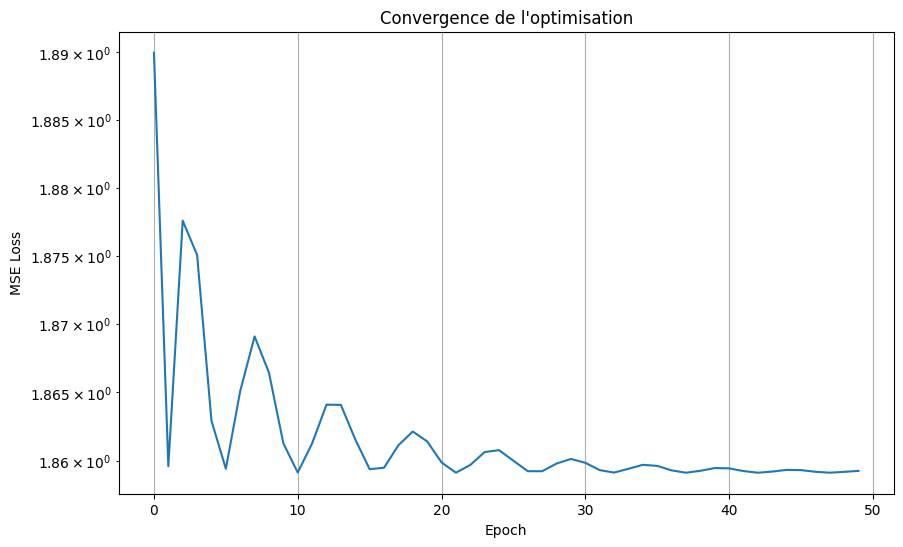

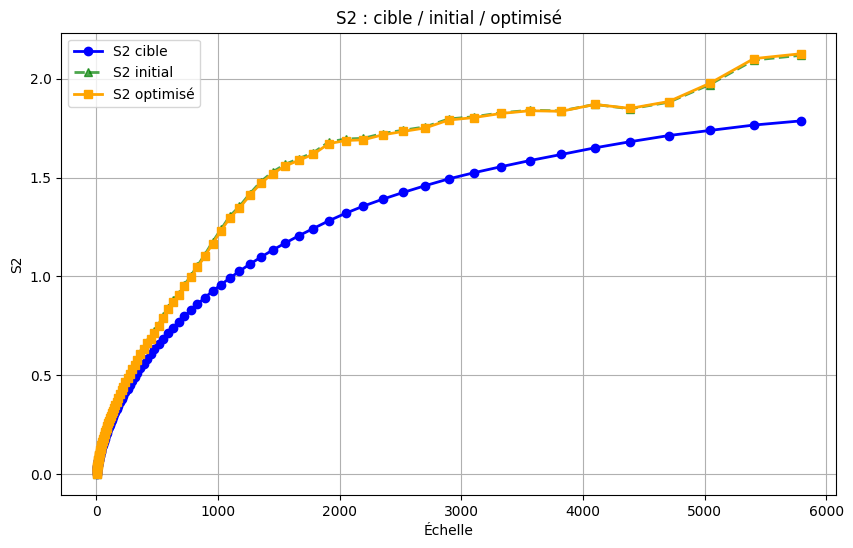

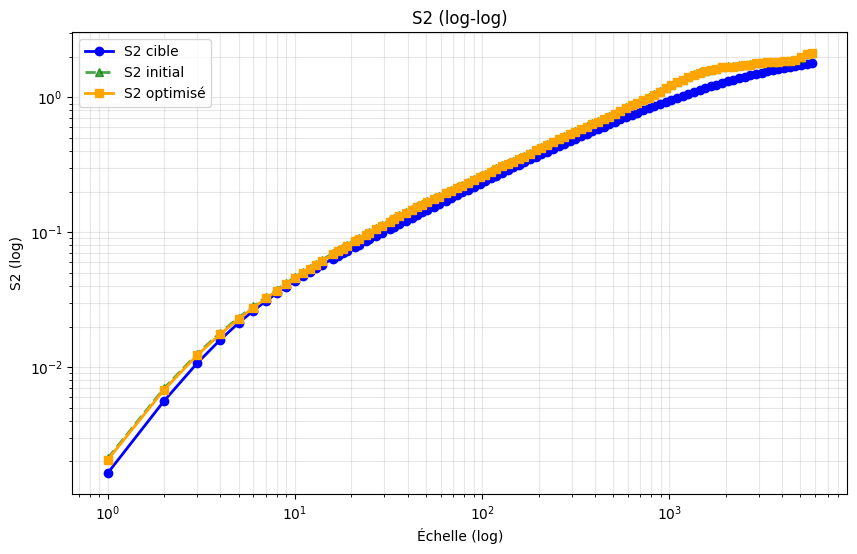

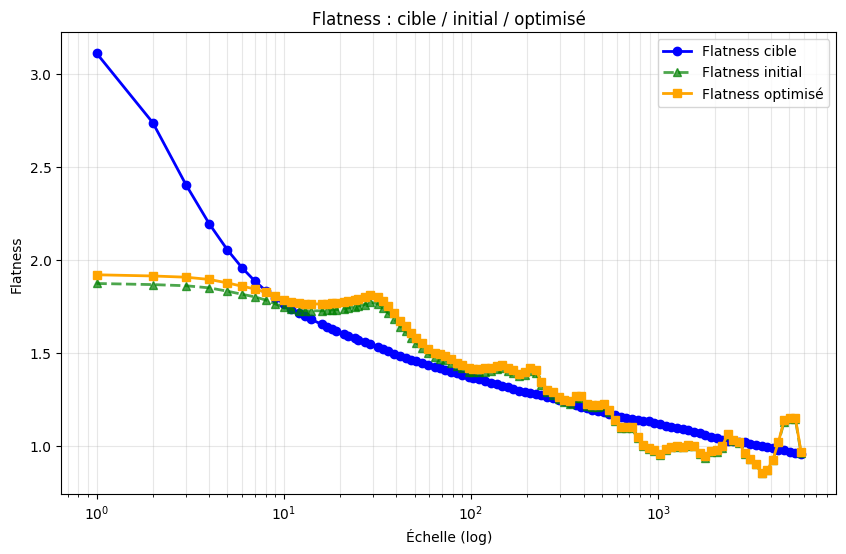

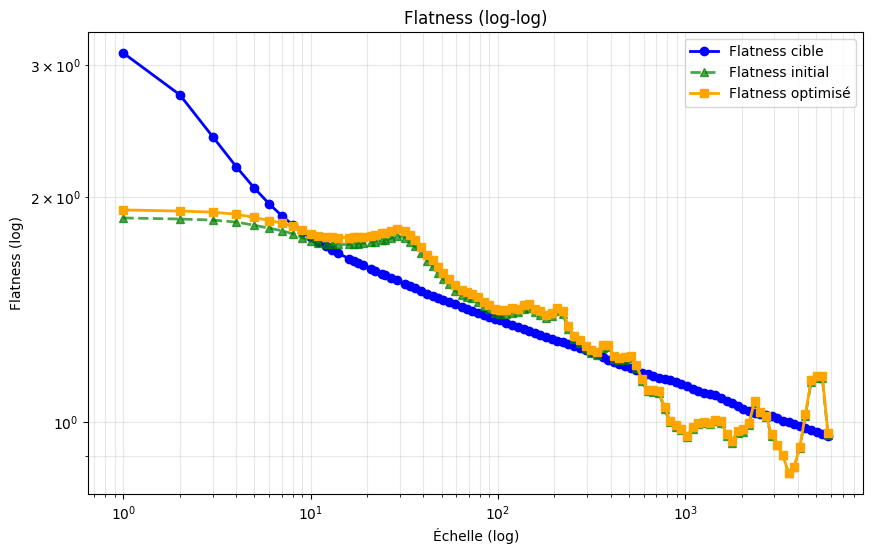

In [4]:
# Cellule 4 : visualisation
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.title("Convergence de l'optimisation")
plt.grid(True); plt.yscale('log'); plt.show()

with torch.no_grad():
    # Génération initiale
    MRW_init = delta_sigma_opt * functions.synthMRWregul_Torch(
        base_noise1, base_noise2, int(N), torch.tensor(c1), torch.tensor(c2), torch.tensor(L), epsilon=1, win=1
    )
    MRW_init_reshaped = torch.reshape(MRW_init, (-1, 2**16))
    moments_init = functions.analyseIncrsTorchcuda(MRW_init_reshaped, scales, device='cpu')
    S2_init = torch.exp(moments_init[:, 0, :]).mean(dim=0)
    flat_init = moments_init[:, 2, :].mean(dim=0)

    # Génération optimisée
    MRW_final = delta_sigma_opt * functions.synthMRWregul_Torch(
        base_noise1, base_noise2, int(N), c1_opt, c2_opt, torch.tensor(L), epsilon=1, win=1
    )
    MRW_final_reshaped = torch.reshape(MRW_final, (-1, 2**16))
    moments_final = functions.analyseIncrsTorchcuda(MRW_final_reshaped, scales, device='cpu')
    S2_final = torch.exp(moments_final[:, 0, :]).mean(dim=0)
    flat_final = moments_final[:, 2, :].mean(dim=0)

# S2 linéaire
plt.figure(figsize=(10, 6))
plt.plot(scales.numpy(), S2.numpy(), 'o-', label='S2 cible', linewidth=2, color='blue')
plt.plot(scales.numpy(), S2_init.numpy(), '^--', label='S2 initial', linewidth=2, color='green', alpha=0.7)
plt.plot(scales.numpy(), S2_final.numpy(), 's-', label='S2 optimisé', linewidth=2, color='orange')
plt.xlabel('Échelle'); plt.ylabel('S2'); plt.title('S2 : cible / initial / optimisé')
plt.legend(); plt.grid(True); plt.show()

# S2 log-log
plt.figure(figsize=(10, 6))
plt.loglog(scales.numpy(), S2.numpy(), 'o-', label='S2 cible', linewidth=2, color='blue')
plt.loglog(scales.numpy(), S2_init.numpy(), '^--', label='S2 initial', linewidth=2, color='green', alpha=0.7)
plt.loglog(scales.numpy(), S2_final.numpy(), 's-', label='S2 optimisé', linewidth=2, color='orange')
plt.xlabel('Échelle (log)'); plt.ylabel('S2 (log)'); plt.title('S2 (log-log)')
plt.legend(); plt.grid(True, which='both', alpha=0.3); plt.show()

# Flatness semilogx
plt.figure(figsize=(10, 6))
plt.semilogx(scales.numpy(), flatness.numpy(), 'o-', label='Flatness cible', linewidth=2, color='blue')
plt.semilogx(scales.numpy(), flat_init.numpy(), '^--', label='Flatness initial', linewidth=2, color='green', alpha=0.7)
plt.semilogx(scales.numpy(), flat_final.numpy(), 's-', label='Flatness optimisé', linewidth=2, color='orange')
plt.xlabel('Échelle (log)'); plt.ylabel('Flatness'); plt.title('Flatness : cible / initial / optimisé')
plt.legend(); plt.grid(True, which='both', alpha=0.3); plt.show()

# Flatness log-log
plt.figure(figsize=(10, 6))
plt.loglog(scales.numpy(), flatness.numpy(), 'o-', label='Flatness cible', linewidth=2, color='blue')
plt.loglog(scales.numpy(), flat_init.numpy(), '^--', label='Flatness initial', linewidth=2, color='green', alpha=0.7)
plt.loglog(scales.numpy(), flat_final.numpy(), 's-', label='Flatness optimisé', linewidth=2, color='orange')
plt.xlabel('Échelle (log)'); plt.ylabel('Flatness (log)'); plt.title('Flatness (log-log)')
plt.legend(); plt.grid(True, which='both', alpha=0.3); plt.show()